In [46]:
from datetime import datetime
from secedgar.filings import Filing, FilingType
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import secedgar
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.chdir(os.path.join(os.getcwd(), ".."))

In [3]:
from api.api_utils import (create_dir, make_patch_spines_invisible, create_ticker2name, 
                           create_combined_data, download_filing_4,
                           InsiderAggregators, calculate_aggregates_per_insider,
                           read_all_form_4, 
                           visualization_insider_stock)

## Relevant Information
**FORM 4** - https://www.sec.gov/files/forms-3-4-5.pdf

### securityadcode:
- Derivatives Holdings: D,DA,DD
- Non-Derivative Holdings:  N,NA,ND

### Transaction Code Transaction:
- **A** - Grant, award, or other acquisition of securities from the company (such as an option)
    - May indicate certainty on results about the company
- **K** - Equity swaps and similar hedging transactions
    - *IGNORE*
- **P** - Purchase of securities on an exchange or from another person
    - Indicates additional purchase (maybe good news or confidence about the ecompany)
- **S** - Sale of securities on an exchange or to another person
    - If lot of sales, may indicate loss of confidence about the company. Not good results
- **D** - Sale or transfer of securities back to the company
    - *IGNORE*
- **F** - Payment of exercise price or tax liability using portion of securities received from the company
    - *IGNORE* - Don't know about, may ignore them
- **M** - Exercise or conversion of derivative security received from the company (such as an option)
    - Mainly options  for employees. They buy (may be good indicator)
- **G** - Gift of securities by or to the insider
    - *IGNORE* Gift for the sons or things like that (maybe useful) Ignore for now
- **V** - A transaction voluntarily reported on Form 4
    - *IGNORE*
- **J** - Other (accompanied by a footnote describing the transaction)
    - *IGNORE*

### directorindirect
- **D**
- **I**


## Resources
https://www.sec.gov/edgar/search/#/q=WMT&dateRange=custom&startdt=2018-07-27&enddt=2018-12-31&category=form-cat2&locationType=located&locationCode=all&forms=3%252C4%252C5&page=1

**Latest** RSS Feed
- https://www.sec.gov/cgi-bin/browse-edgar?action=getcurrent&datea=&dateb=&company=&type=4&SIC=&State=&Country=&CIK=&owner=only&accno=&start=0&count=100
Can go deeper for the XML file


### WMT FORM 4 reports examples
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037607/xslF345X03/form4.xml
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037605/xslF345X03/form4.xml
https://www.sec.gov/Archives/edgar/data/0000104169/000112760218037606/xslF345X03/form4.xml

**Inputs**

In [4]:
tot_companies = 30 # None = All sp100

**Paths**

In [5]:
data_path = os.path.join(os.getcwd(), "data")
data_filings_path = os.path.join(data_path, "filings")
sp_100_file = os.path.join(data_path, "top40_sp500.csv")

create_dir(data_filings_path)

In [6]:
sp100_companies = pd.read_csv(sp_100_file)
sp100_symbols = sp100_companies["Symbol"].unique()

In [ ]:
for symbol in sp100_symbols[:tot_companies]:
    print("symbol: ",symbol)
    download_filing_4(symbol, data_filings_path,
                      start_date=datetime(2020, 5, 1),
                      end_date=datetime(2020, 6, 30))

**Listing CIK**

In [62]:
#ciks = secedgar.utils.get_cik_map().keys()
#for cik in ciks:
#    if cik.startswith("BR"):
#        print(cik)
#
#a = secedgar.filings.cik_lookup.CIKLookup("BRK-B")

In [7]:
data = read_all_form_4(data_filings_path)

In [8]:
data.head()

,transactiondate,transactionshares,transactionpricepershare,transactioncode,officerTitle,rptOwnerName,issuername,ticker,transactionvalue
0,2019-08-24,560000,NaN,M,Chief Executive Officer,COOK TIMOTHY D,Apple Inc.,AAPL,NaN
1,2019-08-12,17500,0.00,M,None,LEVINSON ARTHUR D,Apple Inc.,AAPL,0.0
2,2019-10-07,17010,229.34,S,"Senior Vice President, CFO",Maestri Luca,Apple Inc.,AAPL,3901073.4
3,2019-11-05,37394,0.00,M,None,LEVINSON ARTHUR D,Apple Inc.,AAPL,0.0
4,2019-08-02,1177,0.00,G,None,BELL JAMES A,APPLE INC,AAPL,0.0


In [9]:
data["transactioncode"].unique()

array(['M', 'S', 'G', 'A', 'P', 'F'], dtype=object)

## Visualization

In [10]:
dict_frames = create_combined_data(data)
ticker2name = create_ticker2name(data)

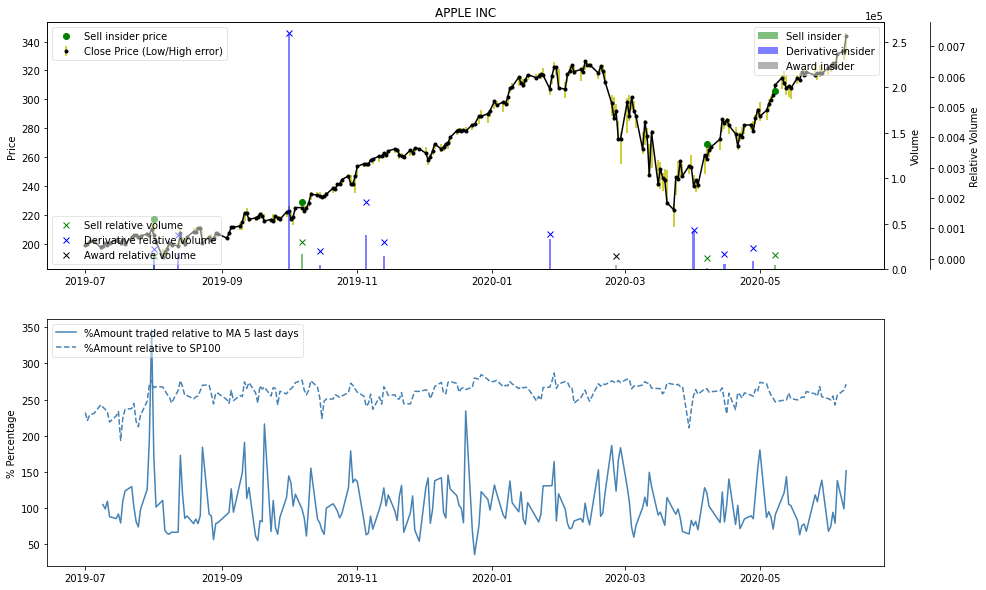

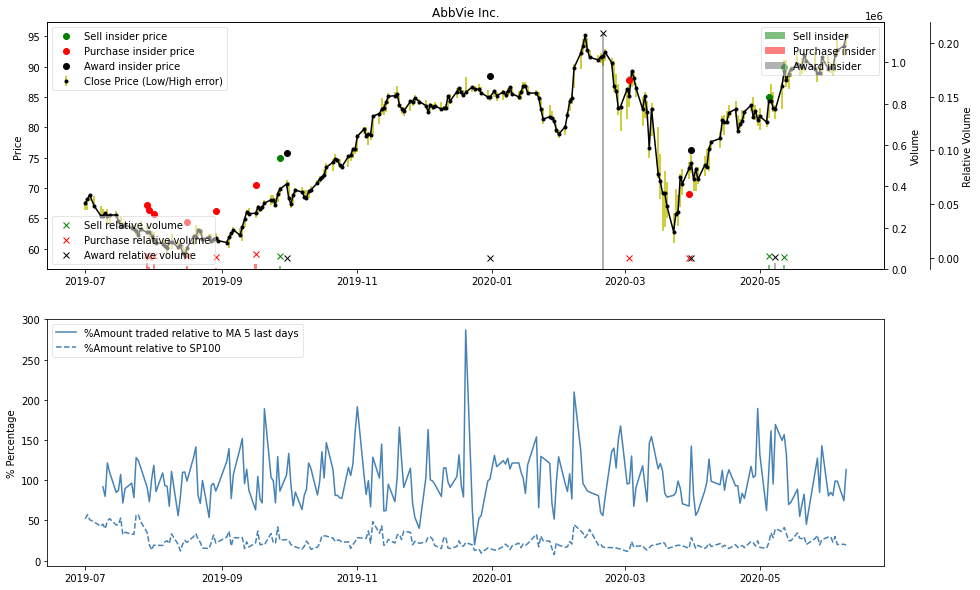

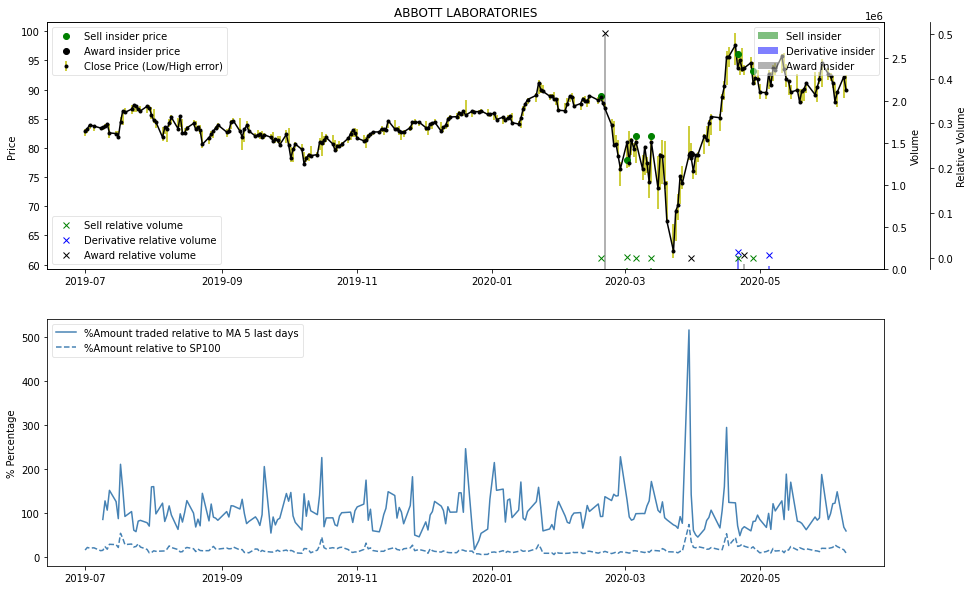

In [42]:
for key, val in dict_frames.items():
    visualization_insider_stock(key, val, ticker2name, save_path=None, from_api=False,) 
                                #start_date=datetime(2019, 10, 1), figsize=(15, 5), 
                                #codes=["S", "P", "M", "A", "F", "G"],
                                #display=["price", "volume"])

In [64]:
dict_top_insiders = {}
for symbol in sp100_symbols[:tot_companies]:
    aggregates_insider = calculate_aggregates_per_insider(data, symbol)
    dict_top_insiders[symbol] = aggregates_insider

In [65]:
dict_top_insiders["AAPL"]

officerTitle transactionpricepershare  \
                                         title        mean_exclude_le_0   
rptOwnerName                                                              
COOK TIMOTHY D         Chief Executive Officer                      NaN   
Maestri Luca        Senior Vice President, CFO                   249.39   
WILLIAMS JEFFREY E                         COO                      NaN   
LEVINSON ARTHUR D                         None                      NaN   
Adams Katherine L.       SVP, GC and Secretary                      NaN   

                   transactionshares transactioncode                \
                                 sum      total_sell total_options   
rptOwnerName                                                         
COOK TIMOTHY D                590580               0             1   
Maestri Luca                  214451               2             2   
WILLIAMS JEFFREY E            196241               0             2   
LEVINSON ARTHUR D              74677               0             4   
Adams Katherine L.             60070               0             1   

                                 
                   total_awards  
rptOwnerName                     
COOK TIMOTHY D                0  
Maestri Luca                  1  
WILLIAMS JEFFREY E            1  
LEVINSON ARTHUR D             1  
Adams Katherine L.            1

In [68]:
ticker = "AAPL"

In [69]:

aggregates_insider = data[data["ticker"] == ticker].groupby("rptOwnerName")\
    .agg({"officerTitle": InsiderAggregators.title,
          "transactionpricepershare": InsiderAggregators.mean_exclude_le_0,
          "transactionshares": np.sum,
          "transactioncode": [InsiderAggregators.total_sell, InsiderAggregators.total_options,
                              InsiderAggregators.total_awards]})\
    .sort_values(by=("transactionshares", "sum"), ascending=False).head(5)

In [70]:
aggregates_insider

officerTitle transactionpricepershare  \
                                         title        mean_exclude_le_0   
rptOwnerName                                                              
COOK TIMOTHY D         Chief Executive Officer                      NaN   
Maestri Luca        Senior Vice President, CFO                   249.39   
WILLIAMS JEFFREY E                         COO                      NaN   
LEVINSON ARTHUR D                         None                      NaN   
Adams Katherine L.       SVP, GC and Secretary                      NaN   

                   transactionshares transactioncode                \
                                 sum      total_sell total_options   
rptOwnerName                                                         
COOK TIMOTHY D                590580               0             1   
Maestri Luca                  214451               2             2   
WILLIAMS JEFFREY E            196241               0             2   
LEVINSON ARTHUR D              74677               0             4   
Adams Katherine L.             60070               0             1   

                                 
                   total_awards  
rptOwnerName                     
COOK TIMOTHY D                0  
Maestri Luca                  1  
WILLIAMS JEFFREY E            1  
LEVINSON ARTHUR D             1  
Adams Katherine L.            1

In [108]:
out = data[data["ticker"] == ticker].groupby(["rptOwnerName"])\
        .agg({"officerTitle": InsiderAggregators.title,
              "transactionpricepershare": InsiderAggregators.mean_exclude_le_0,
              "transactionshares": np.sum}).sort_values("transactionshares", ascending=False).reset_index()
out.columns = ["OwnerName", "OfficerTitle", "AvgPricePerShare", "TotalTransactedShares"]
out["OfficerTitle"] = out["OfficerTitle"].fillna("-")
out["AvgPricePerShare"] = out["AvgPricePerShare"].astype(str).str.replace("nan", "-")

In [109]:
out

,OwnerName,OfficerTitle,AvgPricePerShare,TotalTransactedShares
0,COOK TIMOTHY D,Chief Executive Officer,-,590580
1,Maestri Luca,"Senior Vice President, CFO",249.39,214451
2,WILLIAMS JEFFREY E,COO,-,196241
3,LEVINSON ARTHUR D,-,-,74677
4,Adams Katherine L.,"SVP, GC and Secretary",-,60070
5,O'BRIEN DEIRDRE,Senior Vice President,-,54006
6,GORE ALBERT JR,-,-,35172
7,KONDO CHRIS,Principal Accounting Officer,261.54345,20257
8,JUNG ANDREA,-,-,11873
9,BELL JAMES A,-,-,3460


In [85]:
data[data["ticker"] == ticker].groupby(["rptOwnerName", "transactioncode"])["transactionshares"].sum().to_frame().unstack(1)

transactionshares                            
transactioncode                    A        G         M        S
rptOwnerName                                                    
Adams Katherine L.           45700.0      NaN   14370.0      NaN
BELL JAMES A                   854.0   1177.0    1429.0      NaN
COOK TIMOTHY D                   NaN  30580.0  560000.0      NaN
GORE ALBERT JR                 854.0      NaN   34318.0      NaN
JUNG ANDREA                    854.0      NaN   11019.0      NaN
KONDO CHRIS                   9140.0      NaN    2250.0   8867.0
LEVINSON ARTHUR D              854.0      NaN   73823.0      NaN
Maestri Luca                 45700.0      NaN  150541.0  18210.0
O'BRIEN DEIRDRE              45700.0      NaN    8306.0      NaN
SUGAR RONALD D                 854.0      NaN    1429.0      NaN
WAGNER SUSAN                   854.0      NaN    1429.0      NaN
WILLIAMS JEFFREY E           45700.0      NaN  150541.0      NaN